# VGGVox

In [1]:
import pandas as pd
import os
import numpy as np
import re

In [2]:
if not os.path.exists('VGGVox-PyTorch'):
    ! git clone https://github.com/Derpimort/VGGVox-PyTorch.git
    if not os.path.exists('VGGVox-PyTorch/dataset'):
        os.system('mkdir dataset')
    os.system('rm -r VGGVox-PyTorch/data')
    os.system('cp -r dataset/ VGGVox-PyTorch/dataset/' )
    os.chdir('VGGVox-PyTorch')
    ! pip install -r requirements.txt
    
else:
    if not os.path.exists('VGGVox-PyTorch/dataset'):
        os.system('mkdir dataset')
    os.system('rm -r VGGVox-PyTorch/data')
    os.system(' cp -r dataset/ VGGVox-PyTorch/dataset/' )
    os.chdir('VGGVox-PyTorch')
    ! pip install -r requirements.txt

Cloning into 'VGGVox-PyTorch'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 101 (delta 33), reused 33 (delta 33), pack-reused 61
Receiving objects: 100% (101/101), 64.81 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from tqdm.auto import tqdm
from vggm import VGGM
import argparse
from train import AudioDataset, accuracy, ppdf, LOCAL_DATA_DIR, MODEL_DIR

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import time
%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=VGGM(1251)
model.load_state_dict(torch.load(MODEL_DIR+"VGGM300_BEST_140_81.99.pth", map_location=device))
model.to(device)
model.eval()

### This is to extract an activation from one layer ...
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [17]:
DATA_DIR = '/Users/isabel.rodriguez/Desktop/Isa/MUIT - Machine Learning/DLAS/project/VGGVox-PyTorch'
#DATA_DIR = 'C:\Users\usuario\Documents\Universidad\MUIT\Segundo\2 cuatrimestre\DLAS\Github\Speech-Recognition\VGGVox-PyTorch'
#DATA_DIR = '.'

df = pd.read_csv('./dataset/labels.csv')

Datasets={"test":AudioDataset(df, DATA_DIR, is_train=False)}

Dataloaders={i:DataLoader(Datasets[i], batch_size=1, shuffle=False, num_workers=2) for i in Datasets}

embedding_arr = []

for audio, labels in Dataloaders['test']:
        audio = audio.to(device)
        labels = labels.to(device)
        model.classifier.fc7.register_forward_hook(get_activation('fc7'))
        outputs = model(audio)

        embedding_arr.append(activation['fc7'].cpu().numpy().reshape(-1))

df['Embeddings'] = pd.Series(embedding_arr)

In [18]:
df

,Path,Filename,Label,Embeddings
0,dataset/AVPEPUDEAC0001_pataka.wav,AVPEPUDEAC0001_pataka.wav,0,"[-2.722098e-11, -4.303713e-11, -4.2067477e-10,..."
1,dataset/AVPEPUDEAC0003_pataka.wav,AVPEPUDEAC0003_pataka.wav,0,"[-2.7278487e-11, -5.0162728e-11, -4.5562681e-1..."
2,dataset/AVPEPUDEAC0004_pataka.wav,AVPEPUDEAC0004_pataka.wav,0,"[-2.6095246e-11, -4.8365388e-11, -4.5004483e-1..."
3,dataset/AVPEPUDEAC0005_pataka.wav,AVPEPUDEAC0005_pataka.wav,0,"[-2.7622427e-11, -4.798565e-11, -4.4443252e-10..."
4,dataset/AVPEPUDEAC0006_pataka.wav,AVPEPUDEAC0006_pataka.wav,0,"[-2.7585568e-11, -4.7942553e-11, -4.5115278e-1..."
...,...,...,...,...
95,dataset/AVPEPUDEA0055_pataka.wav,AVPEPUDEA0055_pataka.wav,1,"[-2.649996e-11, -5.064406e-11, -4.786996e-10, ..."
96,dataset/AVPEPUDEA0056_pataka.wav,AVPEPUDEA0056_pataka.wav,1,"[-2.5975931e-11, -4.80464e-11, -4.0962372e-10,..."
97,dataset/AVPEPUDEA0057_pataka.wav,AVPEPUDEA0057_pataka.wav,1,"[-2.4821737e-11, -4.8443645e-11, -4.3704484e-1..."
98,dataset/AVPEPUDEA0058_pataka.wav,AVPEPUDEA0058_pataka.wav,1,"[-3.0116486e-11, -5.325066e-11, -4.9842186e-10..."


## Take first embedding of classes 0 and 1 as reference 

In [19]:
df["Pred_Label"] = 0

speaker_t1 = 0
speaker_t2 = 1
embedding_1 = df[df['Label']== speaker_t1].iloc[0]['Embeddings']
embedding_2 = df[df['Label']== speaker_t2].iloc[0]['Embeddings']

similarity = cosine_similarity(embedding_1.reshape(1,-1), embedding_2.reshape(1,-1))
cosine_distance = 1 - similarity

print('Cosine similarity: ', similarity, ' cosine distance: ', cosine_distance)


print('\n\n-----------------Speaker: ', speaker_t1)
print(df[df['Label']== speaker_t1].iloc[0],'\n')


print('-----------------Speaker: ', speaker_t2)
print(df[df['Label']== speaker_t2].iloc[0])


Cosine similarity:  [[0.84261286]]  cosine distance:  [[0.15738714]]


-----------------Speaker:  0
Path                          dataset/AVPEPUDEAC0001_pataka.wav
Filename                              AVPEPUDEAC0001_pataka.wav
Label                                                         0
Embeddings    [-2.722098e-11, -4.303713e-11, -4.2067477e-10,...
Pred_Label                                                    0
Name: 0, dtype: object 

-----------------Speaker:  1
Path                           dataset/AVPEPUDEA0001_petaka.wav
Filename                               AVPEPUDEA0001_petaka.wav
Label                                                         1
Embeddings    [-2.4653267e-11, -4.4723662e-11, -3.9478065e-1...
Pred_Label                                                    0
Name: 50, dtype: object


In [20]:
for i in range (0, len(df['Embeddings'])):
    if i!=0 and i !=50:
        similarity_sp1 = cosine_similarity(embedding_1.reshape(1,-1), df['Embeddings'][i].reshape(1,-1))
        cosine_distance_sp1 = 1 - similarity_sp1
        similarity_sp2 = cosine_similarity(embedding_2.reshape(1,-1), df['Embeddings'][i].reshape(1,-1))
        cosine_distance_sp2 = 1 - similarity_sp2

        print('Cosine similarity with speaker 1: ', similarity_sp1, ' cosine distance with speaker 1: ', cosine_distance_sp1)
        print('Cosine similarity with speaker 2: ', similarity_sp2, ' cosine distance with speaker 2: ', cosine_distance_sp2)
        
        if min(cosine_distance_sp1,cosine_distance_sp2) == cosine_distance_sp1:
            df['Pred_Label'][i] = 0
        elif min(cosine_distance_sp1,cosine_distance_sp2) == cosine_distance_sp2:
            df['Pred_Label'][i] = 1
        else:
            df['Pred_Label'][i] = np.nan
    else:
        df['Pred_Label'].iloc[0] = 0
        df['Pred_Label'].iloc[50] = 1


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-

Cosine similarity with speaker 1:  [[0.8753692]]  cosine distance with speaker 1:  [[0.12463081]]
Cosine similarity with speaker 2:  [[0.9316246]]  cosine distance with speaker 2:  [[0.06837541]]
Cosine similarity with speaker 1:  [[0.8385476]]  cosine distance with speaker 1:  [[0.16145241]]
Cosine similarity with speaker 2:  [[0.8250194]]  cosine distance with speaker 2:  [[0.17498058]]
Cosine similarity with speaker 1:  [[0.87328833]]  cosine distance with speaker 1:  [[0.12671167]]
Cosine similarity with speaker 2:  [[0.89596146]]  cosine distance with speaker 2:  [[0.10403854]]
Cosine similarity with speaker 1:  [[0.8463576]]  cosine distance with speaker 1:  [[0.15364242]]
Cosine similarity with speaker 2:  [[0.82336366]]  cosine distance with speaker 2:  [[0.17663634]]
Cosine similarity with speaker 1:  [[0.83667094]]  cosine distance with speaker 1:  [[0.16332906]]
Cosine similarity with speaker 2:  [[0.8136653]]  cosine distance with speaker 2:  [[0.18633473]]
Cosine similarit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/i

Cosine similarity with speaker 1:  [[0.8779872]]  cosine distance with speaker 1:  [[0.12201279]]
Cosine similarity with speaker 2:  [[0.8854495]]  cosine distance with speaker 2:  [[0.11455047]]
Cosine similarity with speaker 1:  [[0.83625925]]  cosine distance with speaker 1:  [[0.16374075]]
Cosine similarity with speaker 2:  [[0.8856056]]  cosine distance with speaker 2:  [[0.11439443]]
Cosine similarity with speaker 1:  [[0.82456]]  cosine distance with speaker 1:  [[0.17544001]]
Cosine similarity with speaker 2:  [[0.8282978]]  cosine distance with speaker 2:  [[0.1717022]]
Cosine similarity with speaker 1:  [[0.8390298]]  cosine distance with speaker 1:  [[0.16097021]]
Cosine similarity with speaker 2:  [[0.8248271]]  cosine distance with speaker 2:  [[0.17517292]]
Cosine similarity with speaker 1:  [[0.8080997]]  cosine distance with speaker 1:  [[0.19190031]]
Cosine similarity with speaker 2:  [[0.8172507]]  cosine distance with speaker 2:  [[0.18274927]]
Cosine similarity with

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is tr

## Take the mean of the 10 first embeddings of classes 0 and 1 as reference

In [42]:
df["Pred_Label"] = 0

speaker_t1 = 0
speaker_t2 = 1
embedding_1 = df[df['Label']== speaker_t1].iloc[:10]['Embeddings'].mean()
embedding_2 = df[df['Label']== speaker_t2].iloc[:10]['Embeddings'].mean()


similarity = cosine_similarity(embedding_1.reshape(1,-1), embedding_2.reshape(1,-1))
cosine_distance = 1 - similarity

print('Cosine similarity: ', similarity, ' cosine distance: ', cosine_distance)


print('\n\n-----------------Speaker: ', speaker_t1)
print(df[df['Label']== speaker_t1].iloc[0],'\n')


print('-----------------Speaker: ', speaker_t2)
print(df[df['Label']== speaker_t2].iloc[0])


Cosine similarity:  [[0.98771185]]  cosine distance:  [[0.01228815]]


-----------------Speaker:  0
Path                          dataset/AVPEPUDEAC0001_pataka.wav
Filename                              AVPEPUDEAC0001_pataka.wav
Label                                                         0
Embeddings    [-2.722098e-11, -4.303713e-11, -4.2067477e-10,...
Pred_Label                                                    0
Name: 0, dtype: object 

-----------------Speaker:  1
Path                           dataset/AVPEPUDEA0001_petaka.wav
Filename                               AVPEPUDEA0001_petaka.wav
Label                                                         1
Embeddings    [-2.4653267e-11, -4.4723662e-11, -3.9478065e-1...
Pred_Label                                                    0
Name: 50, dtype: object


In [43]:
for i in range (0, len(df['Embeddings'])):
    
      similarity_sp1 = cosine_similarity(embedding_1.reshape(1,-1), df['Embeddings'][i].reshape(1,-1))
      cosine_distance_sp1 = 1 - similarity_sp1
      similarity_sp2 = cosine_similarity(embedding_2.reshape(1,-1), df['Embeddings'][i].reshape(1,-1))
      cosine_distance_sp2 = 1 - similarity_sp2

      print('Cosine similarity with speaker 1: ', similarity_sp1, ' cosine distance with speaker 1: ', cosine_distance_sp1)
      print('Cosine similarity with speaker 2: ', similarity_sp2, ' cosine distance with speaker 2: ', cosine_distance_sp2)
        
      if min(cosine_distance_sp1,cosine_distance_sp2) == cosine_distance_sp1:
          df['Pred_Label'][i] = 0
      elif min(cosine_distance_sp1,cosine_distance_sp2) == cosine_distance_sp2:
          df['Pred_Label'][i] = 1
      else:
          df['Pred_Label'][i] = np.nan



Cosine similarity with speaker 1:  [[0.91403884]]  cosine distance with speaker 1:  [[0.08596116]]
Cosine similarity with speaker 2:  [[0.90390646]]  cosine distance with speaker 2:  [[0.09609354]]
Cosine similarity with speaker 1:  [[0.9294834]]  cosine distance with speaker 1:  [[0.07051659]]
Cosine similarity with speaker 2:  [[0.93484443]]  cosine distance with speaker 2:  [[0.06515557]]
Cosine similarity with speaker 1:  [[0.9463841]]  cosine distance with speaker 1:  [[0.05361593]]
Cosine similarity with speaker 2:  [[0.95419466]]  cosine distance with speaker 2:  [[0.04580534]]
Cosine similarity with speaker 1:  [[0.94294924]]  cosine distance with speaker 1:  [[0.05705076]]
Cosine similarity with speaker 2:  [[0.9244763]]  cosine distance with speaker 2:  [[0.07552367]]
Cosine similarity with speaker 1:  [[0.95939004]]  cosine distance with speaker 1:  [[0.04060996]]
Cosine similarity with speaker 2:  [[0.9452427]]  cosine distance with speaker 2:  [[0.0547573]]
Cosine similari

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWa

 [[0.9235836]]  cosine distance with speaker 1:  [[0.07641637]]
Cosine similarity with speaker 2:  [[0.93067884]]  cosine distance with speaker 2:  [[0.06932116]]
Cosine similarity with speaker 1:  [[0.90835494]]  cosine distance with speaker 1:  [[0.09164506]]
Cosine similarity with speaker 2:  [[0.927762]]  cosine distance with speaker 2:  [[0.07223803]]
Cosine similarity with speaker 1:  [[0.95709157]]  cosine distance with speaker 1:  [[0.04290843]]
Cosine similarity with speaker 2:  [[0.9599484]]  cosine distance with speaker 2:  [[0.04005158]]
Cosine similarity with speaker 1:  [[0.93678975]]  cosine distance with speaker 1:  [[0.06321025]]
Cosine similarity with speaker 2:  [[0.94884425]]  cosine distance with speaker 2:  [[0.05115575]]
Cosine similarity with speaker 1:  [[0.94987446]]  cosine distance with speaker 1:  [[0.05012554]]
Cosine similarity with speaker 2:  [[0.9502219]]  cosine distance with speaker 2:  [[0.0497781]]
Cosine similarity with speaker 1:  [[0.93360543]] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is tr

Cosine similarity with speaker 1:  [[0.92580175]]  cosine distance with speaker 1:  [[0.07419825]]
Cosine similarity with speaker 2:  [[0.9258908]]  cosine distance with speaker 2:  [[0.0741092]]
Cosine similarity with speaker 1:  [[0.9348922]]  cosine distance with speaker 1:  [[0.06510782]]
Cosine similarity with speaker 2:  [[0.93425417]]  cosine distance with speaker 2:  [[0.06574583]]
Cosine similarity with speaker 1:  [[0.90696764]]  cosine distance with speaker 1:  [[0.09303236]]
Cosine similarity with speaker 2:  [[0.9216891]]  cosine distance with speaker 2:  [[0.07831091]]
Cosine similarity with speaker 1:  [[0.8666053]]  cosine distance with speaker 1:  [[0.13339472]]
Cosine similarity with speaker 2:  [[0.8817393]]  cosine distance with speaker 2:  [[0.11826068]]
Cosine similarity with speaker 1:  [[0.9156133]]  cosine distance with speaker 1:  [[0.08438671]]
Cosine similarity with speaker 2:  [[0.92272353]]  cosine distance with speaker 2:  [[0.07727647]]
Cosine similarity

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is tr

Cosine similarity with speaker 1:  [[0.9197889]]  cosine distance with speaker 1:  [[0.0802111]]
Cosine similarity with speaker 2:  [[0.9315974]]  cosine distance with speaker 2:  [[0.06840259]]
Cosine similarity with speaker 1:  [[0.89623743]]  cosine distance with speaker 1:  [[0.10376257]]
Cosine similarity with speaker 2:  [[0.9071906]]  cosine distance with speaker 2:  [[0.09280938]]
Cosine similarity with speaker 1:  [[0.9420612]]  cosine distance with speaker 1:  [[0.05793881]]
Cosine similarity with speaker 2:  [[0.9399322]]  cosine distance with speaker 2:  [[0.06006777]]
Cosine similarity with speaker 1:  [[0.9560132]]  cosine distance with speaker 1:  [[0.0439868]]
Cosine similarity with speaker 2:  [[0.9540288]]  cosine distance with speaker 2:  [[0.04597121]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWa

In [44]:
df

,Path,Filename,Label,Embeddings,Pred_Label
0,dataset/AVPEPUDEAC0001_pataka.wav,AVPEPUDEAC0001_pataka.wav,0,"[-2.722098e-11, -4.303713e-11, -4.2067477e-10,...",0
1,dataset/AVPEPUDEAC0003_pataka.wav,AVPEPUDEAC0003_pataka.wav,0,"[-2.7278487e-11, -5.0162728e-11, -4.5562681e-1...",1
2,dataset/AVPEPUDEAC0004_pataka.wav,AVPEPUDEAC0004_pataka.wav,0,"[-2.6095246e-11, -4.8365388e-11, -4.5004483e-1...",1
3,dataset/AVPEPUDEAC0005_pataka.wav,AVPEPUDEAC0005_pataka.wav,0,"[-2.7622427e-11, -4.798565e-11, -4.4443252e-10...",0
4,dataset/AVPEPUDEAC0006_pataka.wav,AVPEPUDEAC0006_pataka.wav,0,"[-2.7585568e-11, -4.7942553e-11, -4.5115278e-1...",0
...,...,...,...,...,...
95,dataset/AVPEPUDEA0055_pataka.wav,AVPEPUDEA0055_pataka.wav,1,"[-2.649996e-11, -5.064406e-11, -4.786996e-10, ...",1
96,dataset/AVPEPUDEA0056_pataka.wav,AVPEPUDEA0056_pataka.wav,1,"[-2.5975931e-11, -4.80464e-11, -4.0962372e-10,...",1
97,dataset/AVPEPUDEA0057_pataka.wav,AVPEPUDEA0057_pataka.wav,1,"[-2.4821737e-11, -4.8443645e-11, -4.3704484e-1...",1
98,dataset/AVPEPUDEA0058_pataka.wav,AVPEPUDEA0058_pataka.wav,1,"[-3.0116486e-11, -5.325066e-11, -4.9842186e-10...",0


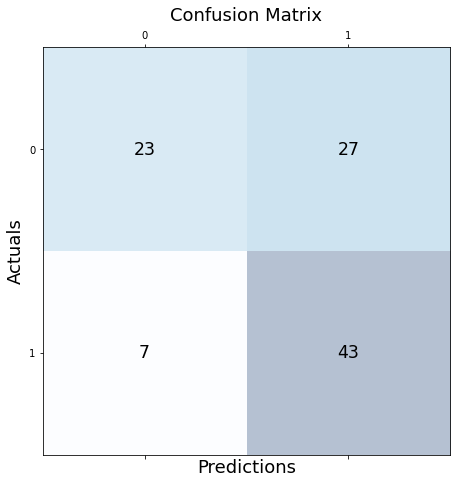

In [45]:
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=df['Label'], y_pred=df['Pred_Label'])
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [46]:
cm_results = {'tn': conf_matrix[0, 0], 'fp': conf_matrix[0, 1], 'fn': conf_matrix[1, 0], 'tp': conf_matrix[1, 1]}

test_acc = (cm_results['tp']+cm_results['tn'])/(cm_results['tp']+cm_results['fp']+cm_results['tn']+cm_results['fn'])
test_precision = cm_results['tp']/(cm_results['tp']+cm_results['fp'])
test_recall = cm_results['tp']/(cm_results['tp']+cm_results['fn'])

print("Test accuracy: {}".format(test_acc))
print("Test precision: {}".format(test_precision))
print("Test recall: {}".format(test_recall))

Test accuracy: 0.66
Test precision: 0.6142857142857143
Test recall: 0.86


In [27]:
n_components = 100 #maximum number of components

X = np.stack(df['Embeddings'].values)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

pca = PCA(n_components = n_components)

pca.fit(X_scaled)

PCA(n_components=100)

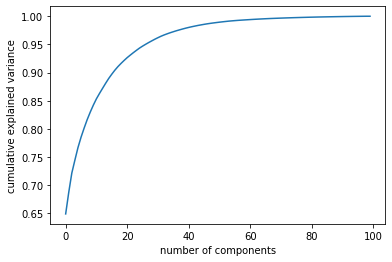

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

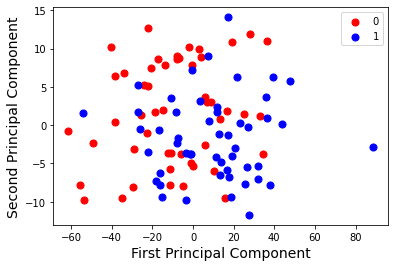

In [29]:
group = df['Label']
cdict = {0: 'red', 1: 'blue'}

Z1 = pca.transform(X_scaled)[:,0]
Z2 = pca.transform(X_scaled)[:,1]

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(Z1[ix], Z2[ix], c = cdict[g], label = g, s = 50)

plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
ax.legend()

In [30]:
time_start = time.time()

X_tsne = TSNE(random_state=123).fit_transform(X_scaled)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 0.526545524597168 seconds


In [31]:
X_tsne.shape

(100, 2)

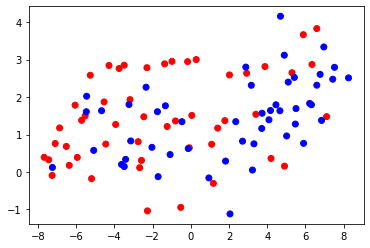

In [32]:
color = []
for label in df['Label']:
    if label == 0:
        color.append('red')
    elif label == 1:
        color.append('blue')

plt.scatter(X_tsne[:,0] ,X_tsne[:,1], c = color)